In [1]:
import os

import numpy as np
import pandas as pd

from google.cloud import bigquery

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('bright')

In [2]:
bq_client = bigquery.Client()

In [89]:
sql = """
select rk.*
       , ifnull(d.avg_door_number , 0) as avg_door_number
from  `predictive_order.tmp_revenue_kar` rk 
      left join 
      (
        select d.outlet_number 
               , avg(d.door_number) as avg_door_number
        from  `cooler_modeling_eu.tbl_door_numbers` d 
        where d._HistoryDate >= '2020-08-01'
              and d._HistoryDate < '2021-08-01'
              and d.CountryCode = 'TR'
        group by d.outlet_number 
      ) d on d.outlet_number = cast(rk.Outlet_Number as string)
"""

data_2 = bq_client.query(query=sql).to_dataframe()

In [90]:
data_2 = data_2.set_index('Outlet_Number')

In [23]:
data = pd.read_excel('Outlet_Rev_Kar 26.08.21.xlsx', sheet_name='Sheet1')

In [26]:
data['Outlet_Number'] = data['Outlet Number'].astype(object)

In [27]:
data.head()

,Outlet Number,Segment,Revenue,Kar,Kar Oran,Outlet_Number
0,9656148,SILVER,1000.29,316.371830,0.316280,9656148
1,9067533,BRONZE,1000.83,241.918171,0.241718,9067533
2,9665097,SILVER,1000.94,311.530672,0.311238,9665097
3,9665169,SILVER,1001.35,316.342787,0.315916,9665169
4,9170641,BRONZE,1001.38,341.121081,0.340651,9170641


In [28]:
data = data.drop('Outlet Number', axis=1)

In [29]:
data.describe()

,Revenue,Kar,Kar Oran
count,153661.000000,153661.000000,153661.000000
mean,25096.534663,7078.256032,0.281281
std,28885.565549,8157.111236,0.030567
min,1000.290000,4.247213,0.001158
25%,9285.650000,2567.259839,0.263271
50%,17466.680000,4873.684065,0.281924
75%,30977.950000,8749.248682,0.299669
max,498655.080000,167145.891553,0.541565


In [30]:
data.head()

,Segment,Revenue,Kar,Kar Oran,Outlet_Number
0,SILVER,1000.29,316.371830,0.316280,9656148
1,BRONZE,1000.83,241.918171,0.241718,9067533
2,SILVER,1000.94,311.530672,0.311238,9665097
3,SILVER,1001.35,316.342787,0.315916,9665169
4,BRONZE,1001.38,341.121081,0.340651,9170641


In [31]:
## set. index Outlet Number

data = data.set_index('Outlet_Number')

---

## Revenue Cluster

In [32]:
data.head()

,Segment,Revenue,Kar,Kar Oran
Outlet_Number,,,,
9656148,SILVER,1000.29,316.371830,0.316280
9067533,BRONZE,1000.83,241.918171,0.241718
9665097,SILVER,1000.94,311.530672,0.311238
9665169,SILVER,1001.35,316.342787,0.315916
9170641,BRONZE,1001.38,341.121081,0.340651


In [33]:
data['log_revenue'] = np.log(data['Revenue'])
data['log_kar'] = np.log(data['Kar'])

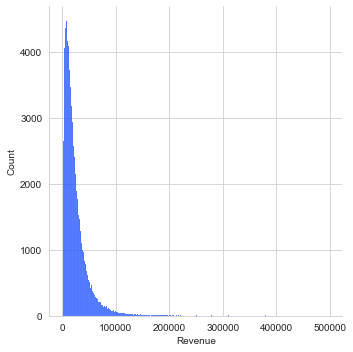

In [34]:
sns.displot(data['Revenue'])

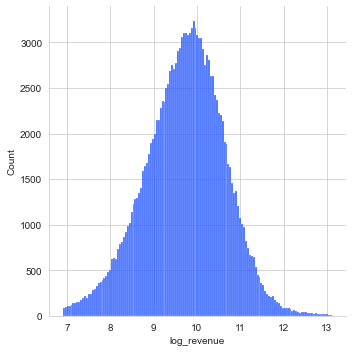

In [35]:
sns.displot(data['log_revenue'])

In [53]:
rev_model_data = data['log_revenue']

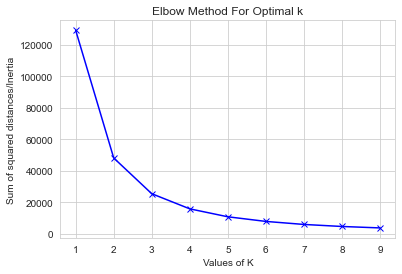

In [43]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_model_data.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
model_rev = KMeans(n_clusters=4, random_state=42, max_iter=1000000, init='k-means++')
model_rev.fit(rev_model_data.values.reshape(-1, 1))
preds = model_rev.predict(rev_model_data.values.reshape(-1, 1))

rev_model_data = pd.concat([rev_model_data
                            , pd.DataFrame({'preds':preds}
                                           , index=rev_model_data.index)], axis=1)

result_1 = pd.merge(rev_model_data, data[['Segment', 'log_kar']], how='inner', left_index=True, right_index=True)
result_1['preds'] = result_1['preds'].astype('category')
# plt.figure(figsize=(15, 15))
sns.scatterplot(data=result_1.reset_index(), hue='preds', y='log_revenue', x='log_kar')
plt.title('Model 1 - Revenue')
plt.show()

In [55]:
result_1['org_revenue'] = np.exp(result_1['log_revenue'])
result_1['org_kar'] = np.exp(result_1['log_kar'])

In [56]:
result_1['preds'].value_counts()

3    56326
2    48391
0    27406
1    21538
Name: preds, dtype: int64

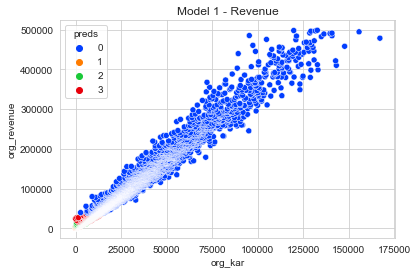

In [57]:
sns.scatterplot(data=result_1.reset_index(), hue='preds', y='org_revenue', x='org_kar')
plt.title('Model 1 - Revenue')
plt.show()

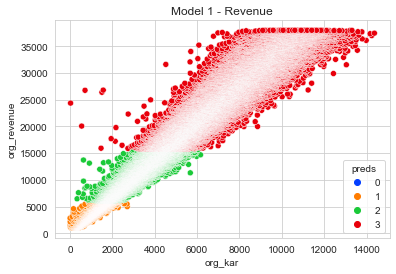

In [58]:
msk = result_1['preds'] != 0
sns.scatterplot(data=result_1[msk].reset_index(), hue='preds', y='org_revenue', x='org_kar')
plt.title('Model 1 - Revenue')
plt.show()

In [59]:
result_1['rank'] = result_1['preds'].apply(lambda x: 
                                           0 if x==1 # orange
                                           else 1 if x==2 # green
                                           else 2 if x==3 # red
                                           else 3
                                          )

In [67]:
result_1['rank'].value_counts()

2    56326
1    48391
3    27406
0    21538
Name: rank, dtype: int64

In [60]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(result_1['org_revenue'].values.reshape(-1,1), result_1['rank'])
clf_preds = clf.predict(result_1['org_revenue'].values.reshape(-1,1))
clf_text = tree.export_text(clf)<
print(clf_text)

|--- feature_0 <= 15807.64
|   |--- feature_0 <= 6170.53
|   |   |--- class: 0
|   |--- feature_0 >  6170.53
|   |   |--- class: 1
|--- feature_0 >  15807.64
|   |--- feature_0 <= 38020.66
|   |   |--- class: 2
|   |--- feature_0 >  38020.66
|   |   |--- class: 3



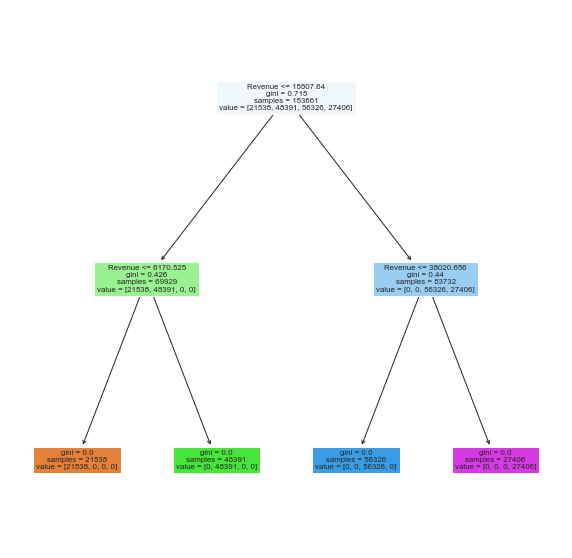

In [61]:
fig = plt.figure(figsize=(10, 10))

_ = tree.plot_tree(clf
                 , feature_names=['Revenue']
                 , filled=True)

rank         0      1      2      3
Segment                            
BRONZE   11384  19116   1517     98
GOLD        25    167   2445  17873
SILVER   10129  29108  52364   9435


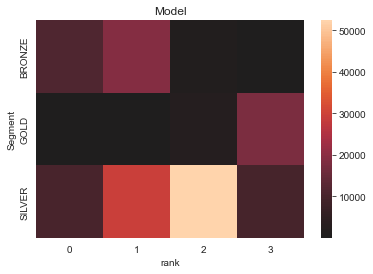

In [62]:
d1 = pd.pivot_table(data=result_1.reset_index()
              , index='Segment'
              , columns='rank'
              , values='Outlet_Number'
              , aggfunc=np.size, sort=True
              , fill_value=0).sort_index()

d1 = d1[sorted(d1.columns)]
print(d1)
sns.heatmap(
            d1
            , center=0
    
).set_title('Model')

plt.show()

rank             0      1      2      3
new_segment                            
Bronze       21538  28444      0      0
Gold             0      0      0  21538
Silver           0  19947  56326   5868


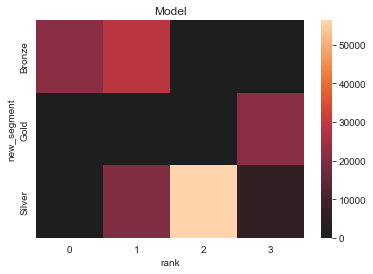

In [88]:
d1 = pd.pivot_table(data=result_2.reset_index()
              , index='new_segment'
              , columns='rank'
              , values='Outlet_Number'
              , aggfunc=np.size, sort=True
              , fill_value=0).sort_index()

d1 = d1[sorted(d1.columns)]
print(d1)
sns.heatmap(
            d1
            , center=0
    
).set_title('Model')

plt.show()

In [70]:
result_1['rank'].value_counts()

2    56326
1    48391
3    27406
0    21538
Name: rank, dtype: int64

In [68]:
result_1.head()

,log_revenue,preds,Segment,log_kar,org_revenue,org_kar,rank
Outlet_Number,,,,,,,
9656148,6.908045,1,SILVER,5.756918,1000.29,316.371830,0
9067533,6.908585,1,BRONZE,5.488600,1000.83,241.918171,0
9665097,6.908695,1,SILVER,5.741498,1000.94,311.530672,0
9665169,6.909104,1,SILVER,5.756826,1001.35,316.342787,0
9170641,6.909134,1,BRONZE,5.832237,1001.38,341.121081,0


In [76]:
data['new_segment'] = data['Revenue'].apply(lambda x: 'Bronze' if (x >= 0 and x< 11520)
                                           else 'Silver' if (x>=11520) and (x<43200)
                                           else 'Gold')

In [85]:
result_1.head()

,log_revenue,preds,Segment,log_kar,org_revenue,org_kar,rank
Outlet_Number,,,,,,,
9656148,6.908045,1,SILVER,5.756918,1000.29,316.371830,0
9067533,6.908585,1,BRONZE,5.488600,1000.83,241.918171,0
9665097,6.908695,1,SILVER,5.741498,1000.94,311.530672,0
9665169,6.909104,1,SILVER,5.756826,1001.35,316.342787,0
9170641,6.909134,1,BRONZE,5.832237,1001.38,341.121081,0


In [86]:
result_2  = pd.merge(result_1, data['new_segment'], left_index=True, right_index=True)

In [77]:
data['new_segment'].value_counts()

Silver    82141
Bronze    49982
Gold      21538
Name: new_segment, dtype: int64

In [78]:
data['Segment'].value_counts()

SILVER    101036
BRONZE     32115
GOLD       20510
Name: Segment, dtype: int64

In [81]:
result_1.groupby('rank', as_index=False).agg({'org_revenue':np.mean})

,rank,org_revenue
0,3,67855.929899
1,0,3942.247514
2,1,10785.882141
3,2,24675.127800


In [82]:
result_1.groupby('rank', as_index=False).agg({'org_revenue':np.median})

,rank,org_revenue
0,3,53994.795
1,0,4065.800
2,1,10682.950
3,2,23659.020


In [83]:
result_1.groupby('rank', as_index=False).agg({'org_revenue':np.min})

,rank,org_revenue
0,3,38022.87
1,0,1000.29
2,1,6170.68
3,2,15808.00


In [84]:
result_1.groupby('rank', as_index=False).agg({'org_revenue':np.max})

,rank,org_revenue
0,3,498655.08
1,0,6170.37
2,1,15807.28
3,2,38018.44


In [92]:
data_2.head()

,Segment,Revenue,Kar,avg_door_number
Outlet_Number,,,,
9487995,GOLD,1628.13,494.961584,9.500000
9090052,GOLD,3085.48,1032.532202,3.833333
9071313,GOLD,3652.15,966.866751,6.250000
9412134,GOLD,4539.21,1322.862154,1.333333
9127967,GOLD,4688.49,1324.087097,5.250000


In [93]:
result_2 = pd.merge(result_2, data_2['avg_door_number'], left_index=True, right_index=True)

In [94]:
result_2.head()

,log_revenue,preds,Segment,log_kar,org_revenue,org_kar,rank,new_segment,avg_door_number
Outlet_Number,,,,,,,,,
9656148,6.908045,1,SILVER,5.756918,1000.29,316.371830,0,Bronze,7.0
9067533,6.908585,1,BRONZE,5.488600,1000.83,241.918171,0,Bronze,1.0
9665097,6.908695,1,SILVER,5.741498,1000.94,311.530672,0,Bronze,0.5
9665169,6.909104,1,SILVER,5.756826,1001.35,316.342787,0,Bronze,3.5
9170641,6.909134,1,BRONZE,5.832237,1001.38,341.121081,0,Bronze,1.5


In [96]:
result_2.groupby('rank', as_index=False).agg({'avg_door_number': np.mean})

,rank,avg_door_number
0,3,3.480496
1,0,1.459574
2,1,1.861682
3,2,2.513045


In [97]:
result_2.groupby('new_segment', as_index=False).agg({'avg_door_number': np.mean})

,new_segment,avg_door_number
0,Bronze,1.623434
1,Gold,3.589751
2,Silver,2.434870


In [98]:
result_2.groupby('Segment', as_index=False).agg({'avg_door_number': np.mean})

,Segment,avg_door_number
0,BRONZE,1.459626
1,GOLD,3.625502
2,SILVER,2.347938


In [99]:
result_2.to_csv('results_20210831.csv', sep='|')